In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import pandas as pd

In [2]:
datagfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#GFP_corrected")
datarfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#RFP")

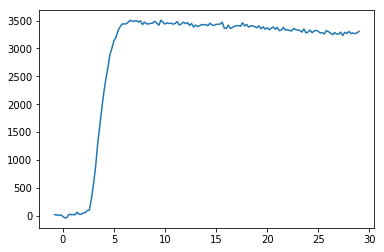

In [3]:
plt.plot(datagfp["Time [h]"],datagfp["#10^3 molecules eGFP crosstalk corrected.2"])

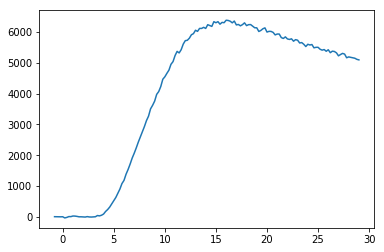

In [4]:
t = datarfp["Time [h]"]
tt = datarfp["Time [h]"]
data = datarfp["#10^3 molecules CayRFP.2"]
noise = np.sqrt(np.abs(data))
plt.plot(t,data)

In [31]:
def DE(t, t0, m, k, beta, delta, offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset


In [38]:
m_ktl_0 = 2e4

tr_0 = 4.5
kmr_0 = 0.3
betr_0 = 0.0421
deltr_0 = 0.03
offr_0 = 0

DE_model = lm.Model(DE)
pars = DE_model.make_params()
pars['t0'].set(value=tr_0,vary=True)
pars['m'].set(value=m_ktl_0,vary=True)
pars['k'].set(value=kmr_0,vary=True)
pars['beta'].set(value=betr_0,vary=True)
pars['delta'].set(value=deltr_0,vary=True)
pars['offset'].set(value=offr_0,vary=True)

out = DE_model.fit(data, pars, t=tt, weights=1/noise)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(DE)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3215
    # data points      = 150
    # variables        = 6
    chi-square         = 693.363820
    reduced chi-square = 4.81502653
    Akaike info crit   = 241.637934
    Bayesian info crit = 259.701746
[[Variables]]
    t0:      3.63882388 +/- 0.04691117 (1.29%) (init = 4.5)
    m:       229804.969 +/- 4.0426e+08 (175915.41%) (init = 20000)
    k:       0.00324466 +/- 5.71628028 (176174.85%) (init = 0.3)
    beta:    0.28563518 +/- 2.84277720 (995.25%) (init = 0.0421)
    delta:   0.03332782 +/- 0.00384606 (11.54%) (init = 0.03)
    offset:  0.90821405 +/- 0.64564267 (71.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(m, k)        = -1.000
    C(m, beta)     =  1.000
    C(k, beta)     = -1.000
    C(beta, delta) = -0.891
    C(m, delta)    = -0.890
    C(k, delta)    =  0.890
    C(t0, k)       =  0.693
    C(t0, m)       = -0.693
    C(t0, beta)    = -0

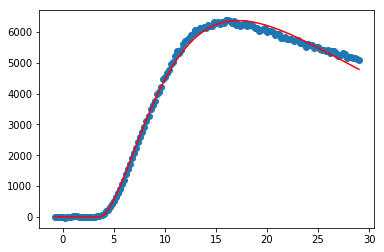

In [33]:
plt.plot(t,data,"o")
plt.plot(t, out.best_fit, 'r-')

In [8]:
import pymc as pm

In [34]:
m_ktl_0 = 2e4

tr_0 = 4.5

kmr_0 = 0.3
kmr_sigma = 0.1

betr_0 = 0.0421
betr_sigma = 0.02

deltr_0 = 0.03
offr_0 = 0

t0 = pm.Uniform('t0',lower=0,upper=15)
m = pm.Uniform('m',lower = 0, upper =5*m_ktl_0)
k = pm.Normal('k',mu=kmr_0,tau=1/kmr_sigma)
beta = pm.Normal('beta',mu=betr_0,tau=1/betr_sigma)
delta = pm.Uniform('delta',lower=0,upper=deltr_0*5)
offset = pm.Uniform('offset',lower=0,upper=5.0)

@pm.deterministic
def DE_pm(t=tt, t0=t0, m=m, k=k, beta=beta, delta=delta, offset=offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset

obs = pm.Normal('obs', mu=DE_pm, tau=1/noise**2, observed=True,
                value=data)

 [-----------------100%-----------------] 130000 of 130000 complete in 2545.5 sec

(array([  1.20000000e+01,   2.49000000e+02,   1.92200000e+03,
          9.78600000e+03,   2.48100000e+04,   3.24370000e+04,
          2.14710000e+04,   7.70700000e+03,   1.42500000e+03,
          1.81000000e+02]),
 array([ 3.56131503,  3.57557798,  3.58984093,  3.60410387,  3.61836682,
         3.63262977,  3.64689272,  3.66115567,  3.67541862,  3.68968157,
         3.70394452]),
 <a list of 10 Patch objects>)

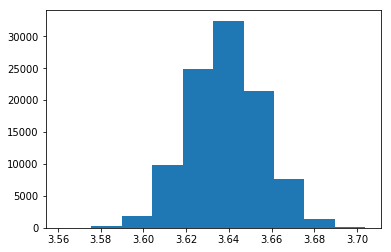

In [35]:
SAMPLES = 100000
BURN = 30000

model = pm.Model([t0, m, k, beta, delta,offset,obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

plt.hist(mcmc.trace('t0')[:])

Plotting k
Plotting offset
Plotting m
Plotting beta
Plotting delta
Plotting t0


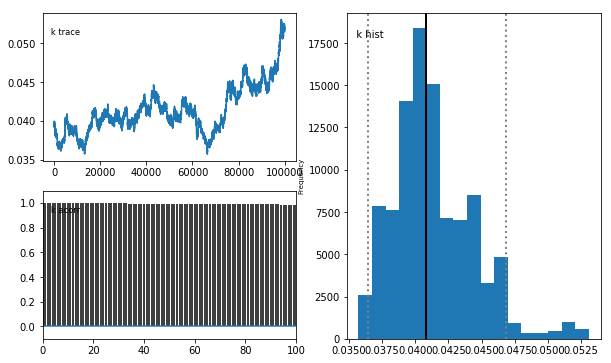

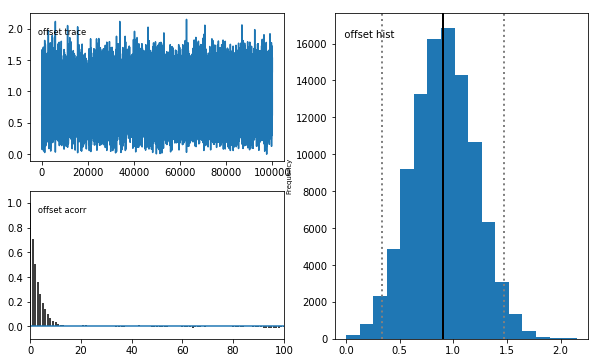

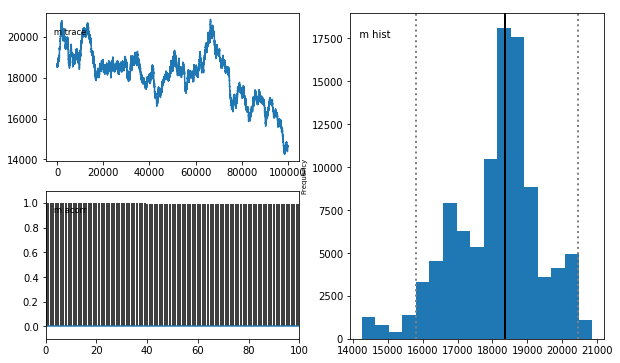

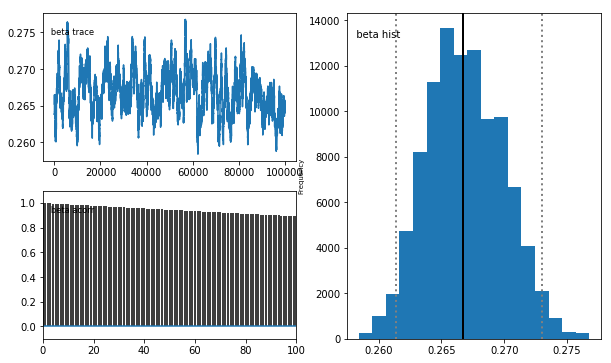

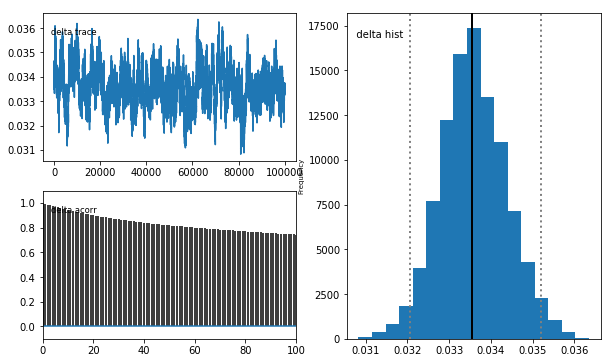

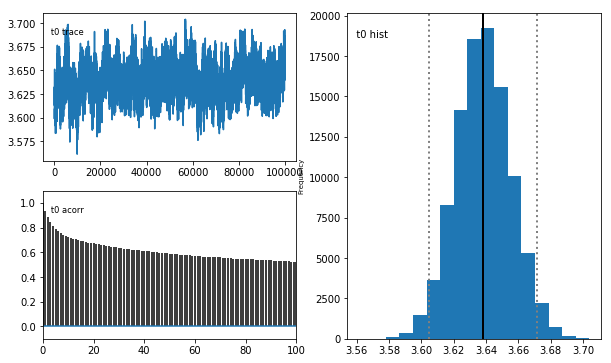

In [36]:
pm.Matplot.plot(mcmc)

In [37]:
mcmc.summary()


k:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.041            0.003            0.0              [ 0.036  0.047]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.037            0.039           0.041          0.043         0.049
	

offset:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.91             0.291            0.002            [ 0.334  1.469]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.343            0.711           0.907          1.109         1.482
	

m:
 
	Mean             SD               MC Error        95% HPD interval
	----------------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
